In [1]:
%matplotlib inline

In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm

In [3]:
kicid = 5705575
times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T
# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

# mmags
mags = dmag * 1000. 

metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

# read in the table of orbits
#orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
#orbits = orbits[orbits.Name == f"kic{kicid}"].iloc[0]

In [2]:
["period", "t0","varpi", "eccen", "logs"]

['period', 't0', 'varpi', 'eccen', 'logs', 'h']

In [20]:
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orbits = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
orbits

Name                   kic5705575
Porb                      537.657
Porb_sig_p               0.913901
Porb_sig_m               0.886882
a1sini/c                  165.242
a1sini/c_sig_p            1.43821
a1sini/c_sig_m            1.44745
e                        0.015609
e_sig_p                  0.015673
e_sig_m                  0.009848
phip                     0.756502
phip_sig_p               0.091603
phip_sig_m               0.090305
varpi                      1.0276
varpi_sig_p              0.576154
varpi_sig_m              0.571995
f(M)Msun                0.0167584
f(M)Msun_sig_p          0.0004411
f(M)Msun_sig_m          0.0004441
gradient                 0.004359
grad_sig_p               0.002555
grad_sig_m               0.002515
t_p                       55376.2
t_p_sig_p                 49.2592
t_p_sig_m                 48.5615
K1_ms                      6700.2
K1_ms_sig_p                  38.1
K1_ms_sig_m                  36.2
median_segment_size           NaN
Name: 127, dty

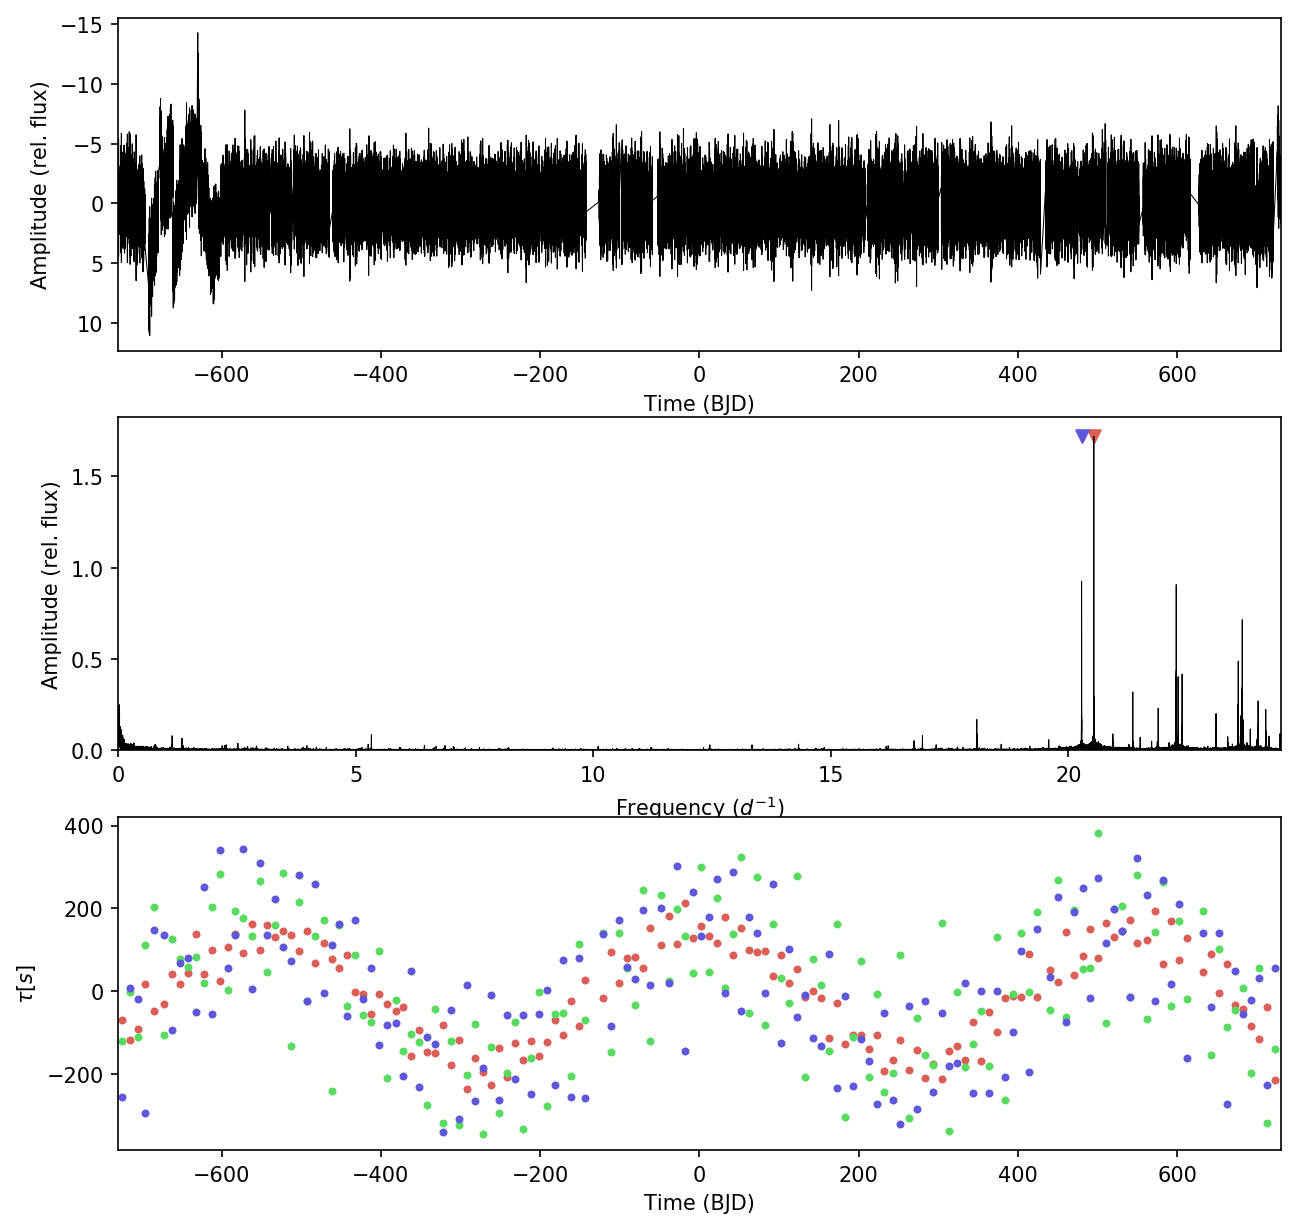

In [4]:
import maelstrom
ms = maelstrom.Maelstrom(times, mags, freq=nu_arr[:3])
ms.setup_orbit_model(period=None)
ms.first_look()

In [5]:
opt = ms.optimize()

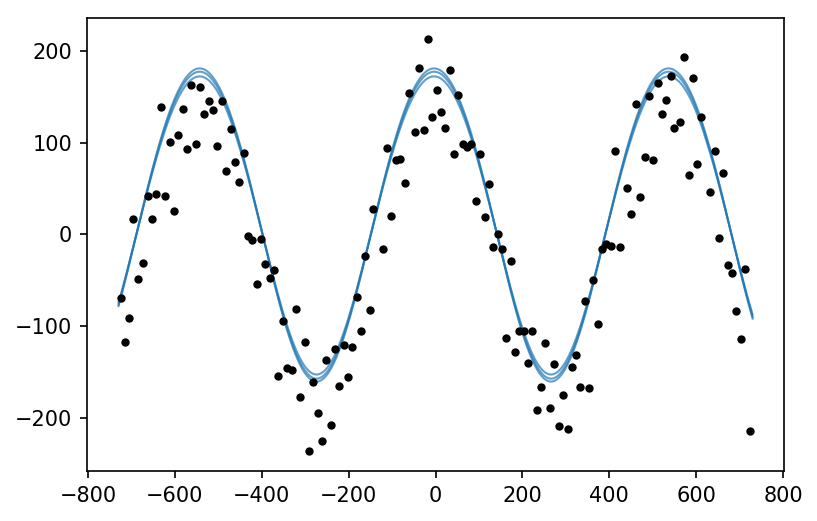

In [6]:
plt.plot(times, ms.evaluate(ms.tau*86400, opt), c="C0", alpha=0.7, lw=1)
a,b = ms.get_time_delay()
plt.plot(a,b[0], ".k")

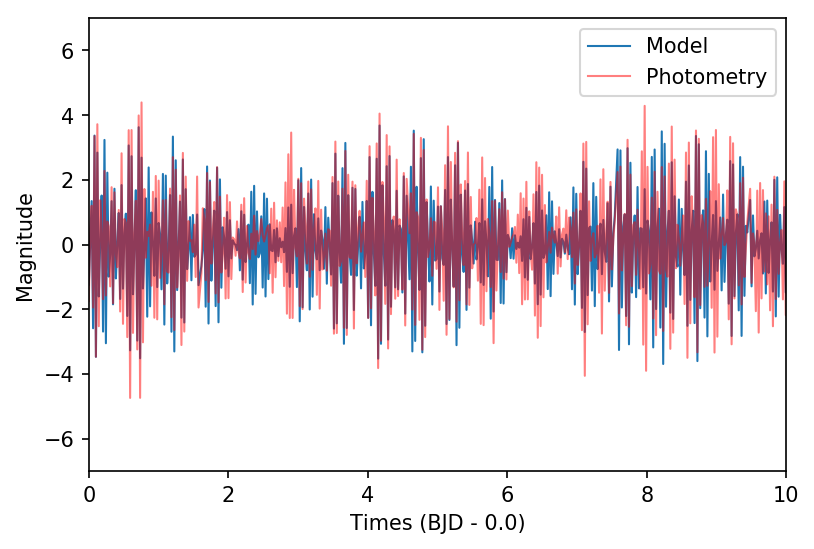

In [7]:
lc_model = ms.evaluate(ms.lc_model, opt)
plt.plot(times, lc_model, c="C0", lw=1, label='Model')
plt.plot(times, mags, alpha=0.5, c='red', lw=1, label='Photometry')

plt.xlim(0,10)
plt.ylim(-7,7)
plt.xlabel('Times (BJD - ' + str(ms.time_mid) + ')')
plt.ylabel('Magnitude')
plt.legend()

In [8]:
pb1_model = ms.pin_orbit_model(opt)

In [9]:
pb1_model

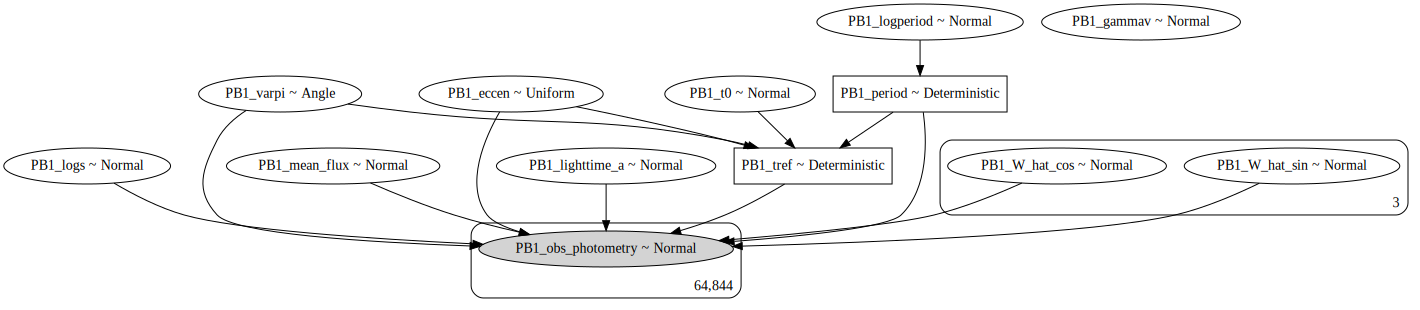

In [10]:
pb1_model.print_model()

In [11]:
rv_JD, rv_RV, rv_err = np.loadtxt(f"data/kic{kicid}_JDrv.txt",delimiter=",", usecols=(0,1,2)).T
rv_JD -= time_mid

pb1_model.add_radial_velocity(rv_JD, rv_RV, lighttime='a')

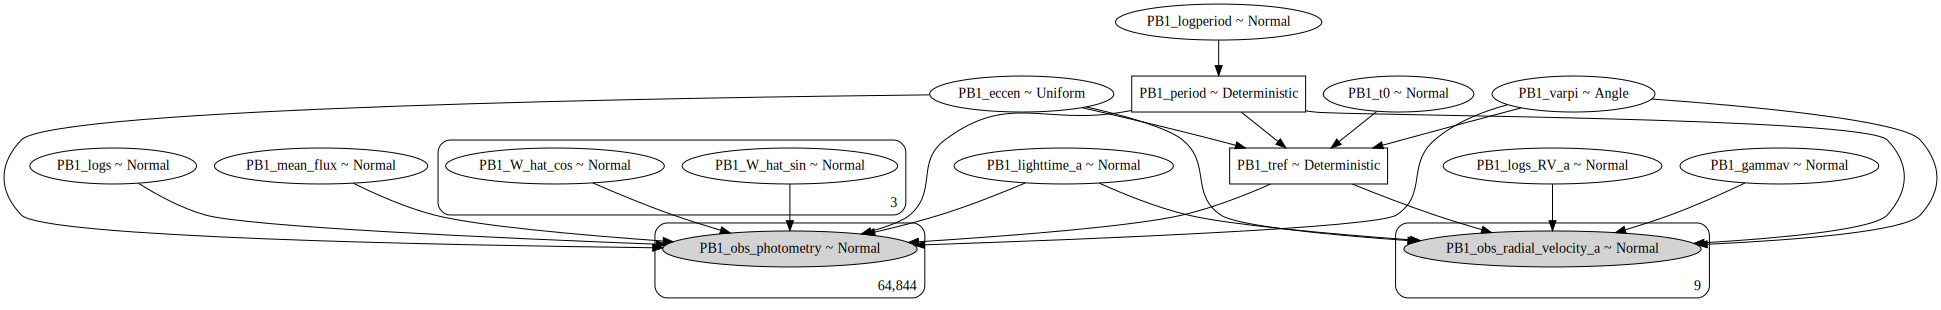

In [13]:
pb1_model.print_model()

In [14]:
opt = pb1_model.optimize()

success: True
initial logp: -140428.72171956341
final logp: -122372.41655157116
success: True
initial logp: -122372.41655157116
final logp: -114037.40329192876
success: True
initial logp: -114037.40329192876
final logp: -113426.2158081765
success: False
initial logp: -113426.2158081765
final logp: -113092.73692274204
success: True
initial logp: -113092.73692274204
final logp: -113089.56696900199
success: False
initial logp: -113089.56696900199
final logp: -113078.16170816947
success: True
initial logp: -113078.16170816947
final logp: -113077.99280181307
success: True
initial logp: -113077.99280181307
final logp: -112808.5053682713
success: False
initial logp: -112808.5053682713
final logp: -112723.26995271181
success: True
initial logp: -112723.26995271181
final logp: -112717.82905604201
success: False
initial logp: -112717.82905604201
final logp: -112440.95980612682


In [15]:
opt

{'PB1_logperiod': array(6.29042572),
 'PB1_t0': array(0.56137174),
 'PB1_varpi_angle__': array([-2.71590067e-05, -5.77292212e-05]),
 'PB1_eccen_interval__': array(-2.78594146),
 'PB1_logs': array(0.31362368),
 'PB1_lighttime_a': array(-165.41682124),
 'PB1_gammav': array(-37.47332004),
 'PB1_mean_flux': array(0.00080193),
 'PB1_W_hat_cos': array([-1.29624412,  0.91286031, -0.93527238]),
 'PB1_W_hat_sin': array([-1.14955929,  0.60266852,  0.15669741]),
 'PB1_logs_RV_a': array(0.64083955),
 'PB1_period': array(539.3829083),
 'PB1_varpi': array(-2.01052991),
 'PB1_eccen': array(0.05809746),
 'PB1_tref': array(228.08432689)}

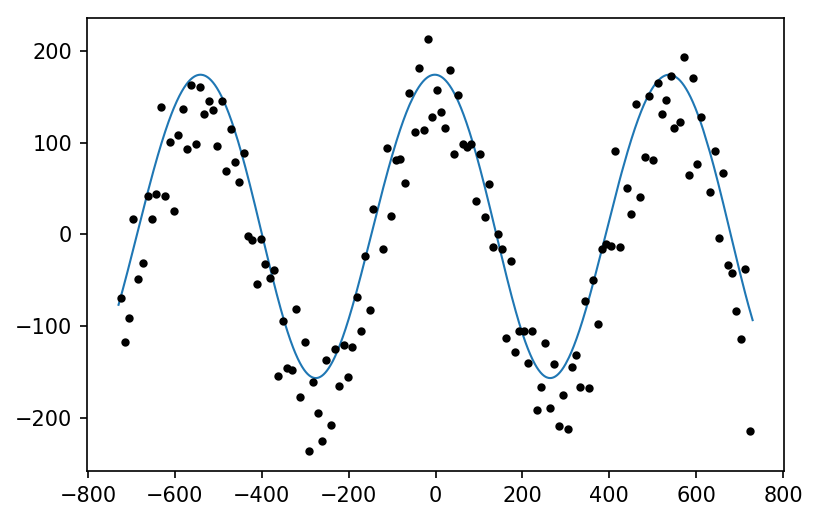

In [16]:
plt.plot(times, pb1_model.evaluate(pb1_model.tau*86400, opt), c="C0", alpha=1, lw=1)
a,b = pb1_model.get_time_delay()
plt.plot(a,b[0], ".k")

In [18]:
trace = pb1_model.sample(tune=1000, draws=1000, start=opt)

Sampling 2 chains: 100%|██████████| 604/604 [16:26<00:00,  1.18s/draws]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [PB1_logs_RV_a, PB1_W_hat_sin, PB1_W_hat_cos, PB1_mean_flux, PB1_gammav, PB1_lighttime_a, PB1_logs, PB1_eccen, PB1_varpi, PB1_t0, PB1_logperiod]
Sampling 2 chains: 100%|██████████| 2000/2000 [19:14<00:00,  1.22draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7538348502314105, but should be close to 0.9. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.727283001124415, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2de18d68>,
      dtype=object)

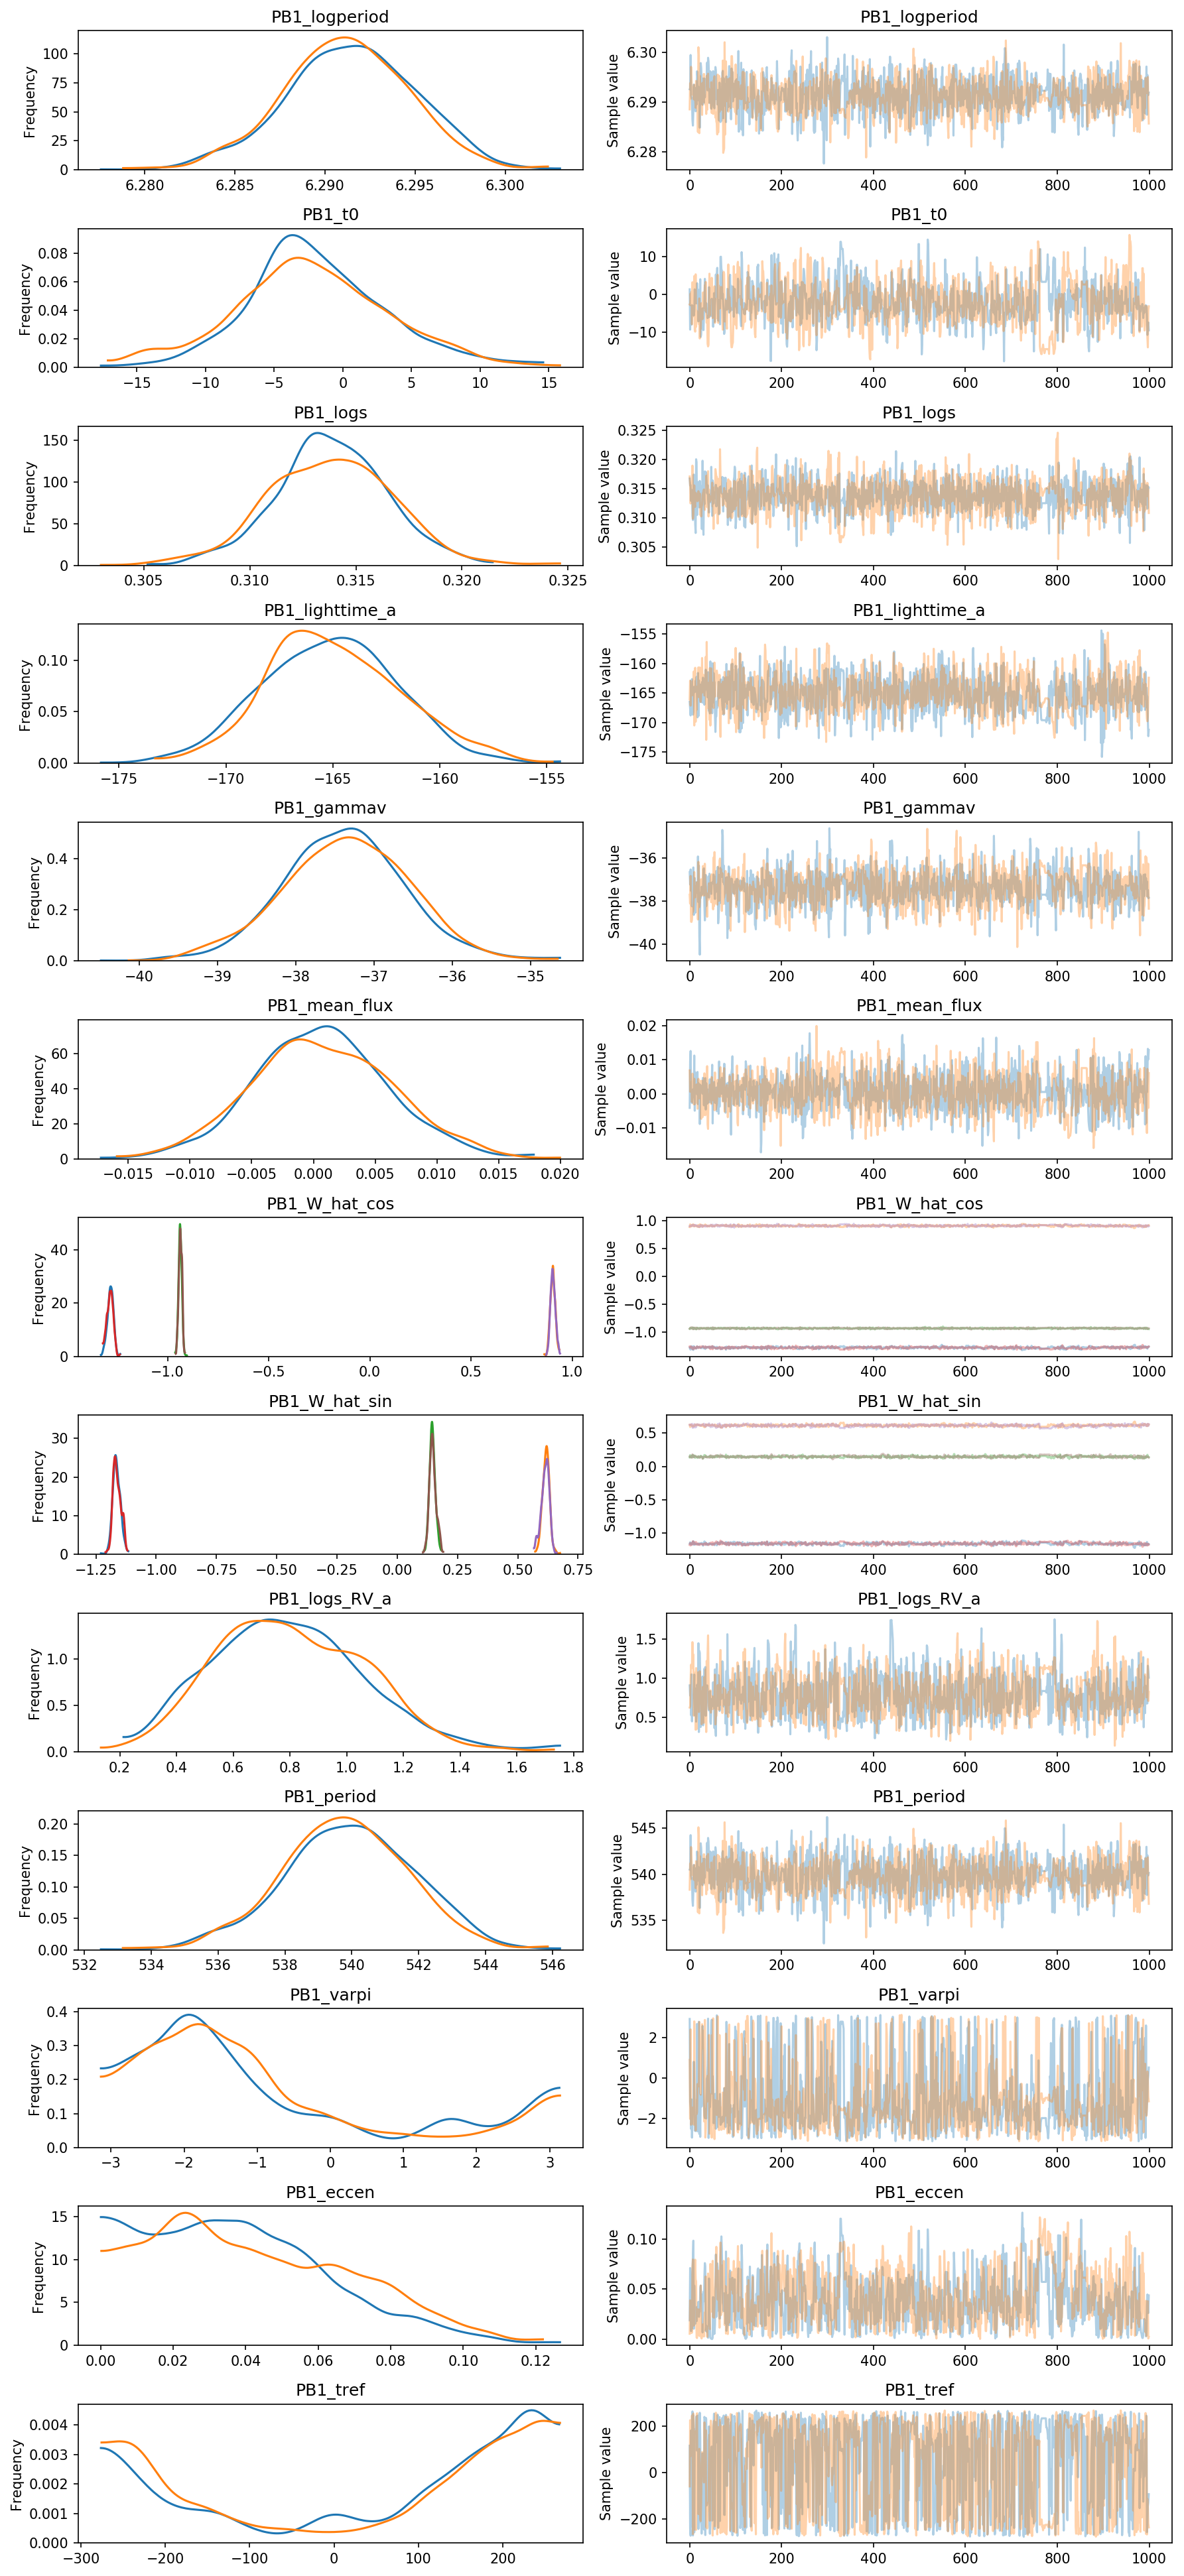

In [19]:
import pymc3 as pm
pm.traceplot(trace)

In [24]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
PB1_logperiod,6.291242,0.003513,0.000090,6.283929,6.297677,1424.047167,1.001616
PB1_t0,-2.135412,5.366102,0.236678,-12.182321,10.049276,432.816407,1.001380
PB1_logs,0.313781,0.002754,0.000082,0.308300,0.319138,953.899103,0.999675
PB1_lighttime_a,-165.068987,3.106316,0.096144,-171.487622,-159.351077,957.669333,1.001552
PB1_gammav,-37.384057,0.790476,0.024422,-38.913734,-35.784264,977.074436,0.999846
PB1_mean_flux,0.000604,0.005459,0.000158,-0.009745,0.011945,1069.737544,0.999595
PB1_W_hat_cos__0,-1.283329,0.015122,0.000694,-1.314561,-1.256775,342.648768,1.003551
PB1_W_hat_cos__1,0.904227,0.012130,0.000493,0.882065,0.929663,503.648334,1.001085
PB1_W_hat_cos__2,-0.936854,0.007952,0.000224,-0.952960,-0.922576,1189.043506,1.002306
PB1_W_hat_sin__0,-1.163608,0.016219,0.000718,-1.190477,-1.129879,403.244077,1.002962


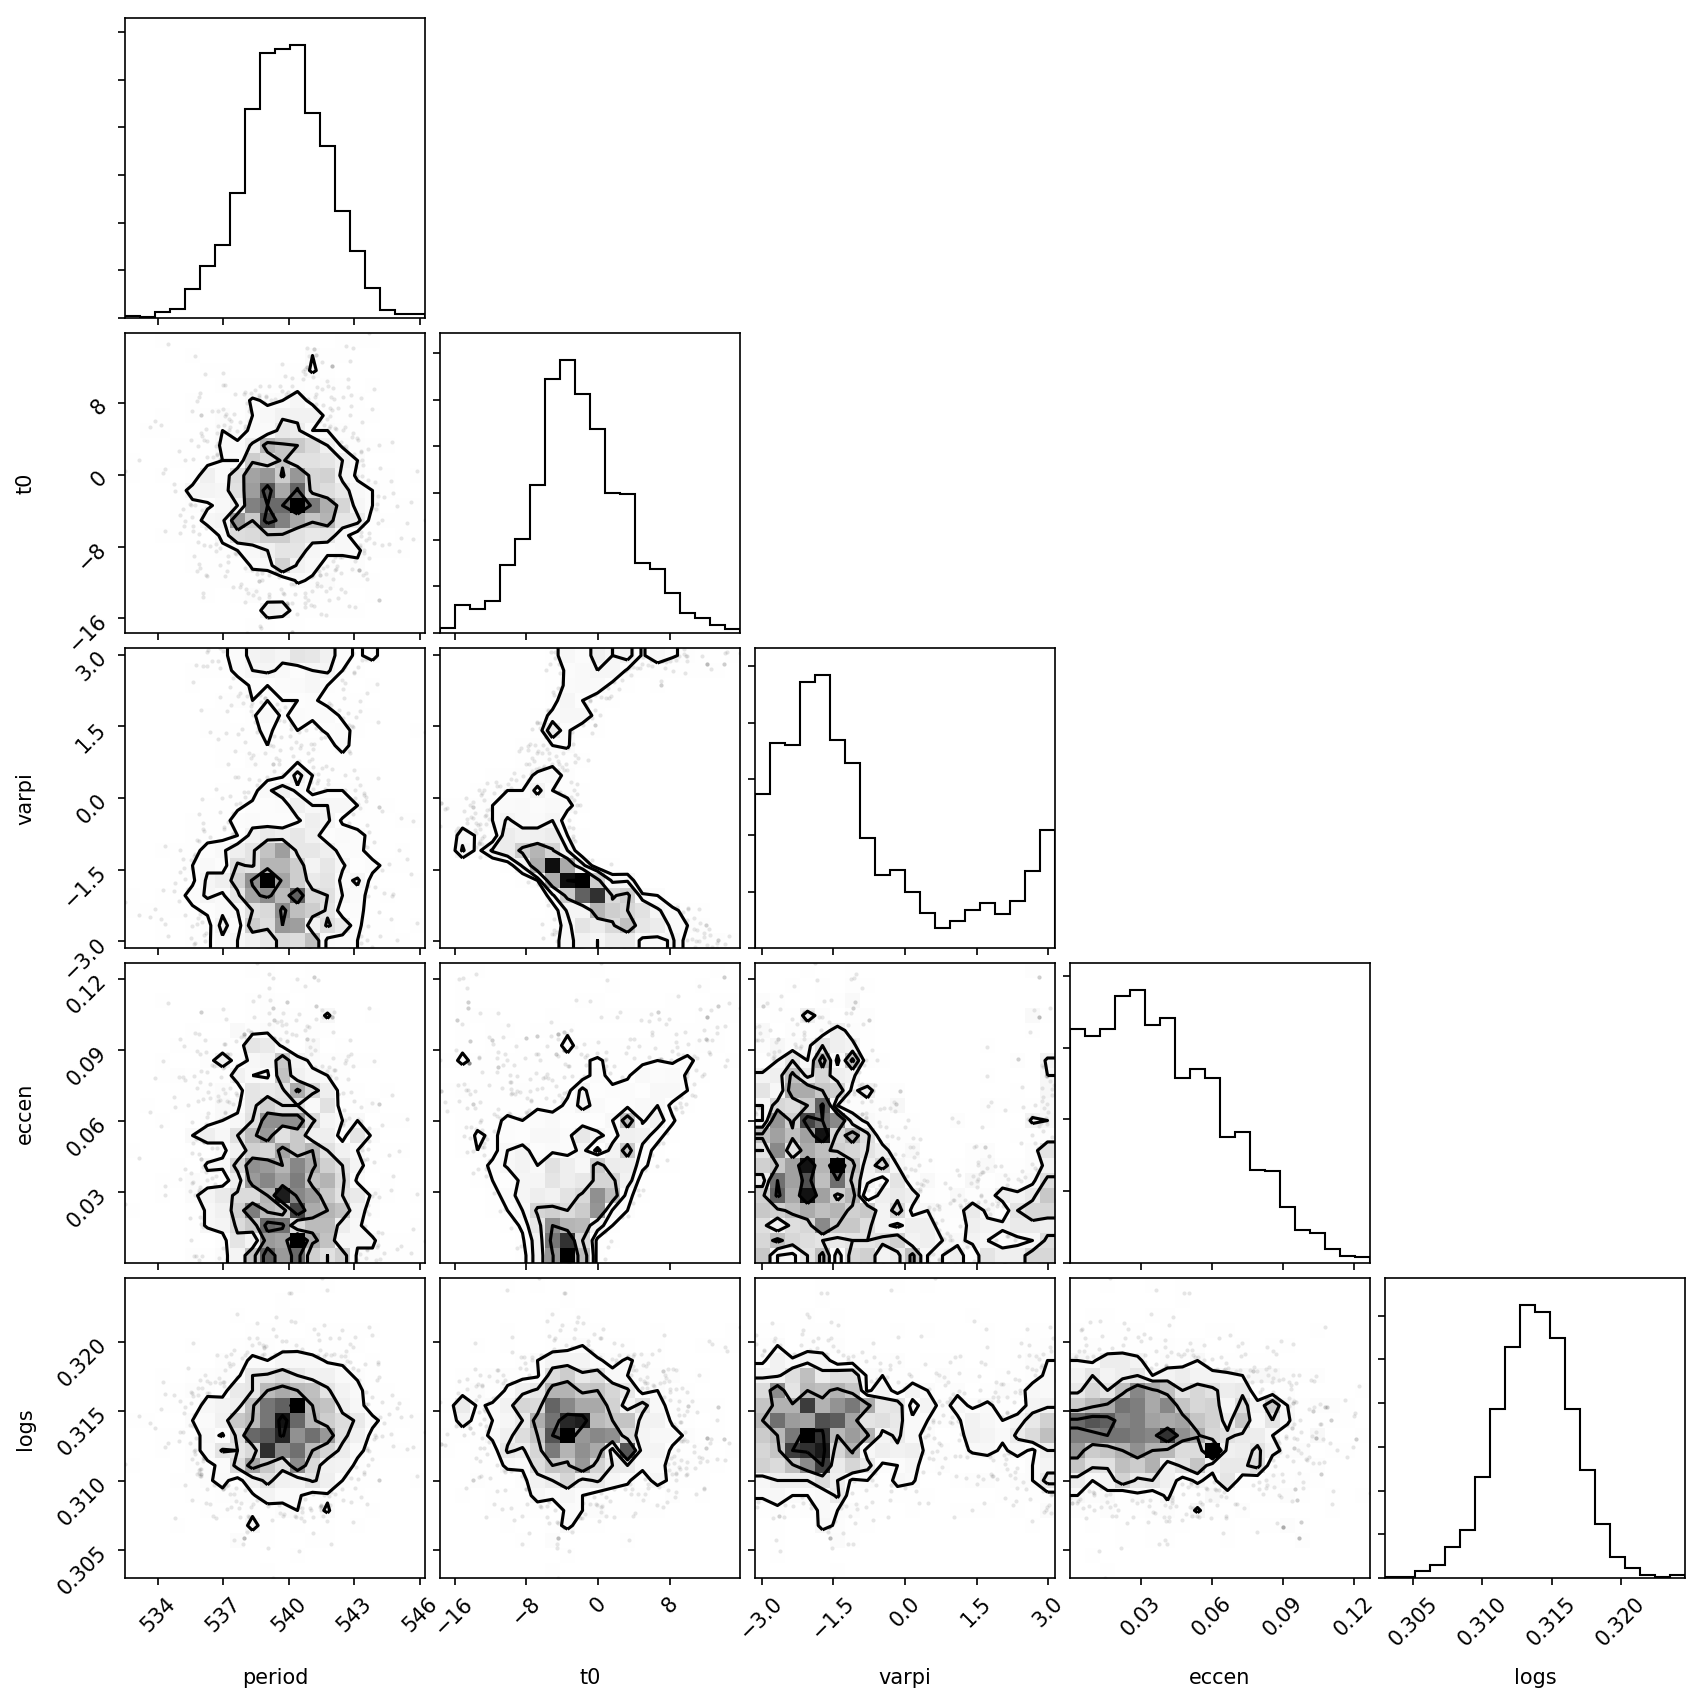

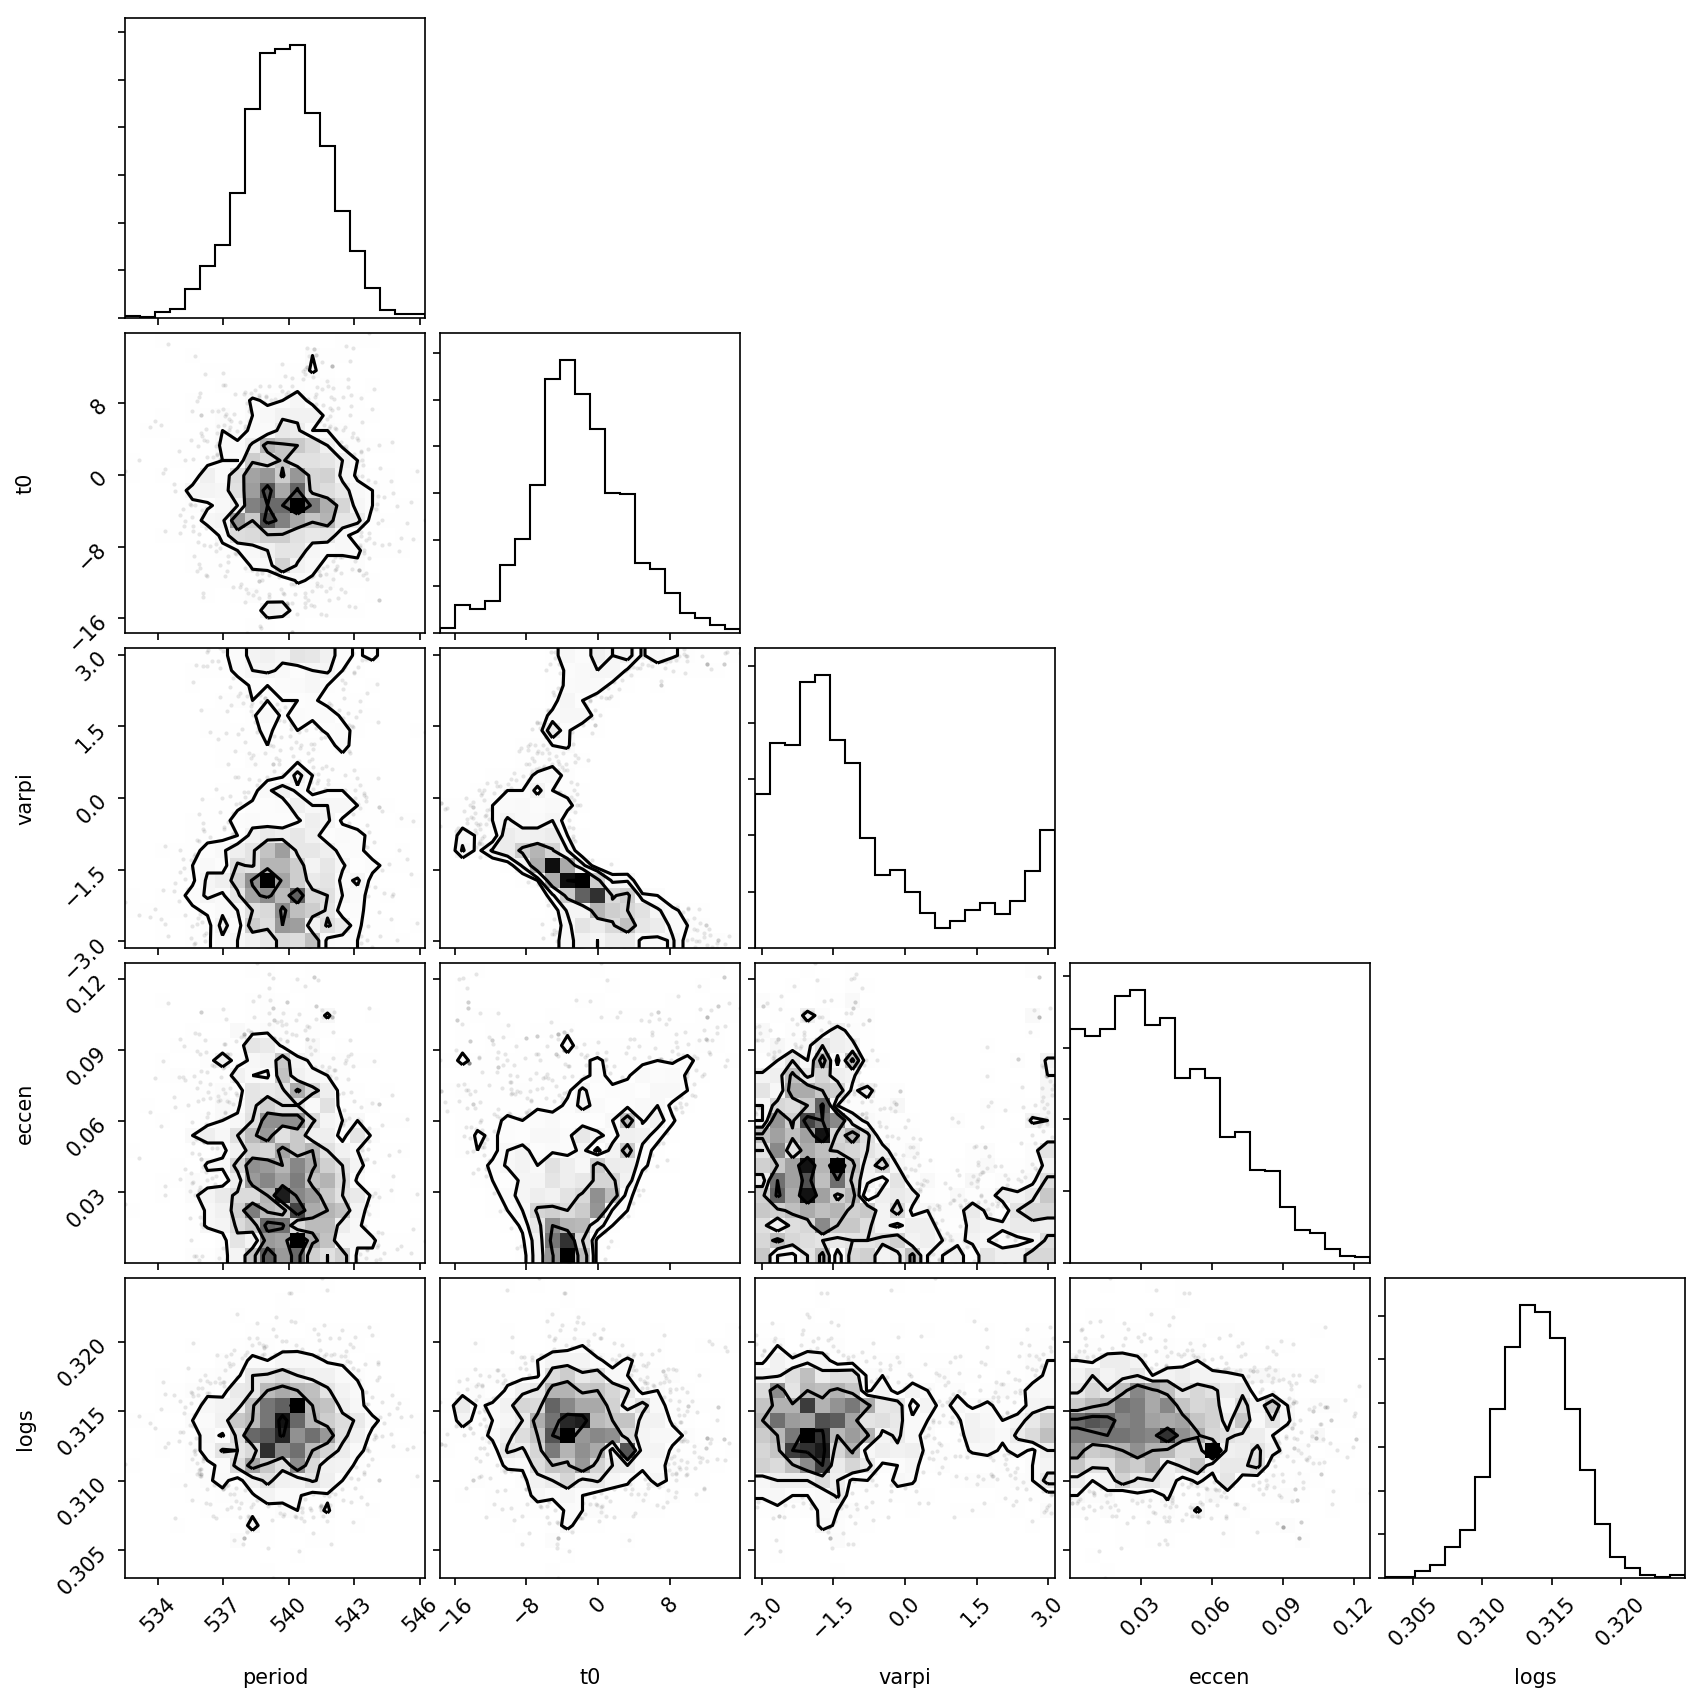

In [27]:
import corner
varnames=["PB1_period", "PB1_t0","PB1_varpi", "PB1_eccen", "PB1_logs"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
for k in samples.columns:
    if "_" in k:
        samples[k.replace("PB1_", "")] = samples[k]
        del samples[k]
corner.corner(samples)